# Congestión

En este documento se realizara un dataframe en el cual se tendran los tiempos de viaje, hora de salida y de llegada de cada viaje para primero contar, en una determinada hora (tengo metido en la cabeza a las 6 am XD) cuantas personas no han llegado a sus destinos, como una primera medida de congestion y revisar esto mediante un intervalo, el cual yo considero minimo de media hoa, aunque eso debe tener un argumento mas fuerte como la demora promedio por viaje.

Antes de esto se deben conocer cantidades determinantes como la demora promedio de todos los viajes, y tambien podria ser una medida de congestion medir este paramertro dependiendo de la hora, y estas cantidades habra que norlmalizarlas, pero con respecto a que???? no estoy seguro pero a medida que avance el problema y hablando con Hurtado lo averiguare. 

In [1]:
#Se llaman las librerias necesarias
import pandas as pd
import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt
import operator
import itertools
import datetime
from scipy.optimize import curve_fit

In [2]:
# Se importa la base de datos necesaria parael problema
great_df = pd.read_csv('Viajes_en_Bogota.csv')
great_df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,id_hogar,Estado,Utam,Sector,Seccion,Manzana,...,p9v_id_municipio,p9v_municipio,p10v_hora_salida,p11v_condujo_vehiculo,p13v_condujo_bicicleta,p15v_subsidio_SITP,Sexo,Coordenadas_origen,Coordenadas_destino,distancia
0,0,0,0,7089,17081,2,UTAM9,8534,3,14,...,NaN,NaN,05:20:00,2.0,2.0,4.0,Hombre,"(4.76497701069, -74.025204743)","(4.66837226947, -74.0708821769)",11.823790
1,1,1,1,7090,17081,2,UTAM9,8534,3,14,...,NaN,NaN,05:20:00,2.0,2.0,4.0,Hombre,"(4.66837226947, -74.0708821769)","(4.76497701069, -74.025204743)",11.823790
2,2,2,2,7091,17081,2,UTAM9,8534,3,14,...,NaN,NaN,14:00:00,2.0,2.0,4.0,Mujer,"(4.76497701069, -74.025204743)","(4.60097651263, -74.06565509720001)",18.682519
3,3,3,3,7092,17081,2,UTAM9,8534,3,14,...,NaN,NaN,14:00:00,2.0,2.0,4.0,Mujer,"(4.60097651263, -74.06565509720001)","(4.76497701069, -74.025204743)",18.682519
4,4,4,4,7096,P07096,1,UTAM9,8534,3,14,...,NaN,NaN,06:30:00,2.0,2.0,4.0,Mujer,"(4.76497701069, -74.025204743)","(4.75960172111, -74.0223691045)",0.672520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104675,104675,104936,105471,40322,P02949,1,UTAM570,20,5,8,...,NaN,NaN,06:05:00,2.0,2.0,4.0,Mujer,"(4.5961099049300005, -74.2015525696)","(4.5961099049300005, -74.2015525696)",0.000000
104676,104676,104937,105472,40323,P02949,1,UTAM570,20,5,8,...,NaN,NaN,06:05:00,2.0,2.0,4.0,Mujer,"(4.5961099049300005, -74.2015525696)","(4.5961099049300005, -74.2015525696)",0.000000
104677,104677,104938,105473,40324,P02949,1,UTAM570,20,5,8,...,NaN,NaN,06:05:00,2.0,2.0,4.0,Mujer,"(4.5961099049300005, -74.2015525696)","(4.59470614806, -74.1942596605)",0.824004
104678,104678,104939,105474,40333,P02950,1,UTAM570,20,5,8,...,NaN,NaN,08:00:00,2.0,9.0,4.0,Mujer,"(4.5938930252, -74.2076557761)","(4.5961099049300005, -74.2015525696)",0.720240


## Funciones importantes 

In [3]:
# Cuenta la cantidad de un elemento sobre todos los elementos de un arreglo 
def count(array):
    y_dist = np.asarray([list(array).count(x) for x in np.unique(array)])
    x_dist = np.asarray([x for x in np.unique(array)])
    return x_dist, y_dist

#Cambia los datos de hora a tipo datatime 
def to_time(clmn):
    array = []
    for i in clmn:
        array.append(datetime.datetime.strptime(i, '%H:%M:%S').time())
    return array

# Funcion en la que se aplica el metodo de newman
def newman(array):
    my_array = []
    for i in range(len(array)):
        P = sum(array[i:])
        my_array.append(P)
    return my_array

### Analisis y distribucion de la duracion de los tiempos de viaje en la red

In [5]:
great_df['duracion'].agg('average')

50.0723920519679

El tiempo promedio de viajes para la red de Bogotá y Suacha es $\bar{t} = 50,08$ minutos

In [6]:
great_df[['hora_inicio_viaje','p10v_hora_salida', 'hora_llegada', 'duracion']]

,hora_inicio_viaje,p10v_hora_salida,hora_llegada,duracion
0,18:00:00,05:20:00,18:10:00,10
1,06:00:00,05:20:00,06:10:00,10
2,15:30:00,14:00:00,16:15:00,45
3,06:20:00,14:00:00,06:25:00,5
4,12:00:00,06:30:00,20:00:00,480
...,...,...,...,...
104675,06:20:00,06:05:00,06:50:00,30
104676,16:00:00,06:05:00,17:10:00,70
104677,12:45:00,06:05:00,14:00:00,75
104678,13:30:00,08:00:00,13:36:00,6


In [7]:
duracion = np.asarray(great_df[great_df['duracion'] <= 200]['duracion'])
duracion_x, duracion_y = count(duracion) 
y_normal = duracion_y/sum(duracion_y)
dur_newman = newman(y_normal)

In [8]:
np.mean(duracion)

44.8920536816225

In [9]:
sum(np.asarray(great_df['duracion']))

5241578

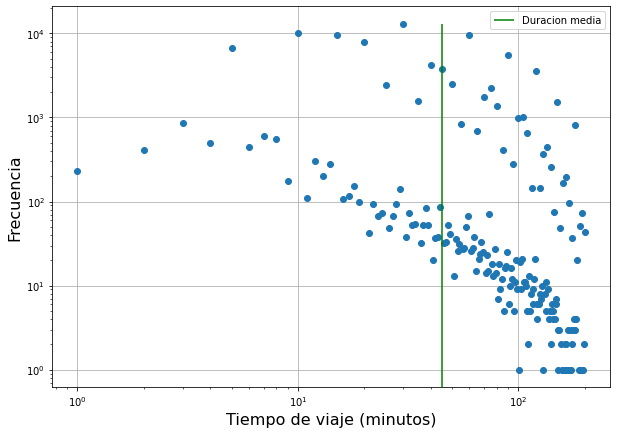

In [10]:
# Distribucion 
plt.figure(figsize = (10,7))
plt.loglog(duracion_x, duracion_y, 'o')
plt.xlabel('Tiempo de viaje (minutos)', fontsize = 16)
plt.ylabel('Frecuencia', fontsize = 16)
plt.vlines(np.mean(duracion), 0, 1.3e4, color = 'g',label = 'Duracion media')
plt.legend()
plt.grid()

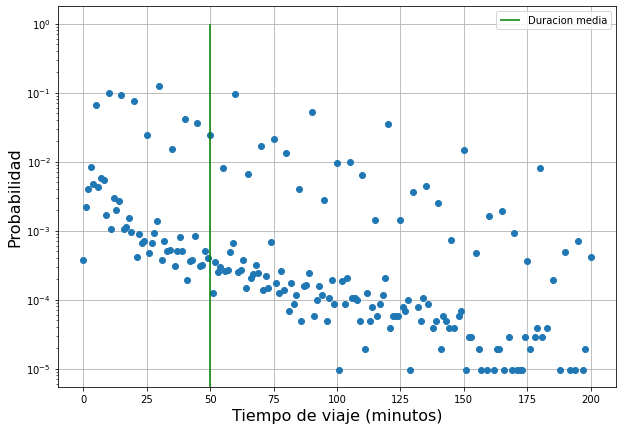

In [11]:
plt.figure(figsize = (10,7))
plt.semilogy(duracion_x, y_normal, 'o')
plt.xlabel('Tiempo de viaje (minutos)', fontsize = 16)
plt.ylabel('Probabilidad', fontsize = 16)
plt.vlines(great_df['duracion'].agg('average'), 0, 1, color = 'g',label = 'Duracion media')
plt.legend()
plt.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


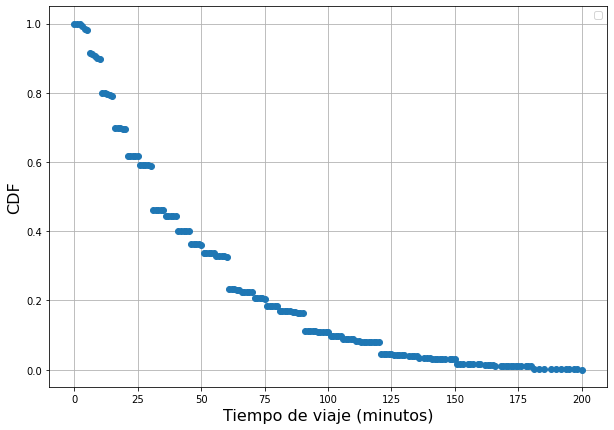

In [12]:
plt.figure(figsize = (10,7))
plt.plot(duracion_x, dur_newman, 'o')
plt.xlabel('Tiempo de viaje (minutos)', fontsize = 16)
plt.ylabel('CDF', fontsize = 16)
#plt.vlines(great_df['duracion'].agg('average'), 0, 1, color = 'g',label = 'Duracion media')
plt.legend()
plt.grid()

Hay algo que me inquieta a la hora de ver la distribucion de la duracion de los viajes y es la presencia de tres estructuras aparentemente independientes, en donde cada una sigue una tendencia por separado, y no una tendencia global, e incluso, dependiendo de como se vea, se pueden incluso ver cuatro estructuras en esta grafica, lo cual es inquietante.

Algo que se puede hacer con la duracion de los viajes es por medio de tranporte, localidad (considerando a soacha una localidad) y por estrato a ver como se comporta esa joda.

In [13]:
great_df[great_df['duracion'] < 200][['hora_inicio_viaje','p10v_hora_salida', 'hora_llegada', 'duracion', 'zat_origen', 'zat_destino']]

,hora_inicio_viaje,p10v_hora_salida,hora_llegada,duracion,zat_origen,zat_destino
0,18:00:00,05:20:00,18:10:00,10,13.0,225.0
1,06:00:00,05:20:00,06:10:00,10,225.0,13.0
2,15:30:00,14:00:00,16:15:00,45,13.0,477.0
3,06:20:00,14:00:00,06:25:00,5,477.0,13.0
5,09:10:00,06:30:00,09:20:00,10,13.0,14.0
...,...,...,...,...,...,...
104675,06:20:00,06:05:00,06:50:00,30,765.0,765.0
104676,16:00:00,06:05:00,17:10:00,70,765.0,765.0
104677,12:45:00,06:05:00,14:00:00,75,765.0,766.0
104678,13:30:00,08:00:00,13:36:00,6,774.0,765.0


Revisando la duracion de los viajes se notan cosas raras, como el hecho de que excisten viajes cuya duracion es $t = 0$, y son viajes entre zonas bastante separadas, o casos tambien mas raros en donde la duracion es algo absurdo, como mas de 1000 minutos. Hay unos viajes que duran mas o menos 12 horas, van y llegan al mismo lado, podria decirse que es casi que el viaje de la casa al trabajo y de regreso XD.

Teniendo en cuenta estos dos extremos atipicos me planteo la gran posibilidad de filtrar tambien estos datos de mi base de datos, la gracia seria consultarlo con hurtado.

In [ ]:
len(great_df)*98/100

Entre el 87% y el 88% los viajes duran menos de 100 munitos, es decir, mas de una hora y media, por lo cual, tan solo un 13% de los viajes duran mas que esto, los cuales son relativamente pocos, pero es totalmente plausible que los viajes puedan durar hasta tres horas dentro de la ciudad. Los viajes que duran menos de 200 minutos, tres horas y 20 minutos representan entre 98 y 99% de los viajes realizados, por lo cual esto podria tomarse como una cota superior para el filtrado de los datos, ya que esos datos de al rededor de doce horas es casi que ir y volver de la casa, seria ver el lugar de origen o el motivo de estos viajes para ver las rarezas ocultas de estos. 

Al hacerle el proceso de Newman se nota que la distribucion de las duraciones sigue aproximadamente una ley exponencilal, quien lo diria XD

A partir de aca se va a ahcer la serie de tiempo de la duracion de viaje promedio

In [30]:
df_duracion = great_df[['hora_inicio_viaje', 'hora_llegada', 'duracion']]
df_duracion = df_duracion[df_duracion['duracion'] <= 200]
df_duracion['hora_inicio_viaje'] = to_time(df_duracion['hora_inicio_viaje'])
df_duracion['hora_llegada'] = to_time(df_duracion['hora_llegada'])

In [15]:
df_duracion['duracion'].agg('average')

44.8920536816225

In [31]:
horas = []
dur_media = []
num_viajes = []
hora = datetime.time(0, 0)
hora_out = datetime.time(22, 0)
hora_in = datetime.time(2,0)
df = df_duracion[(df_duracion['hora_inicio_viaje'] >= hora_out) & 
             (df_duracion['hora_llegada'] <= hora_in) &
             (df_duracion['hora_inicio_viaje'] <= datetime.time(23, 59)) & 
             (df_duracion['hora_llegada'] >= hora)]
dur_media.append(df['duracion'].agg('average'))
horas.append(0)
num_viajes.append(len(df))
for i in range(1,24):
    hora = datetime.time(i, 0)
    df = df_duracion[(df_duracion['hora_inicio_viaje'] <= hora) & (df_duracion['hora_llegada'] >= hora)]
    dur_media.append(df['duracion'].agg('average'))
    horas.append(i)
    num_viajes.append(len(df))

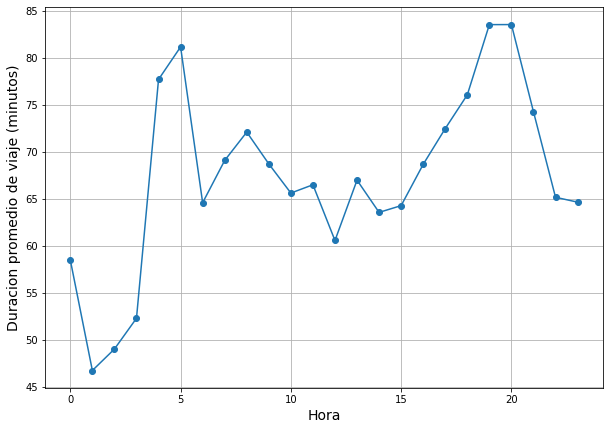

In [17]:
plt.figure(figsize = (10, 7))
plt.plot(horas, dur_media, 'o', linestyle = '-')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Duracion promedio de viaje (minutos)', fontsize = 14)
plt.grid()

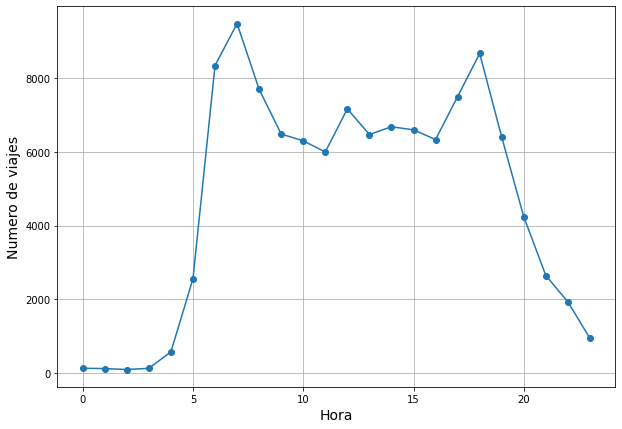

In [18]:
plt.figure(figsize = (10, 7))
plt.plot(horas, num_viajes, 'o', linestyle = '-')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Numero de viajes', fontsize = 14)
plt.grid()

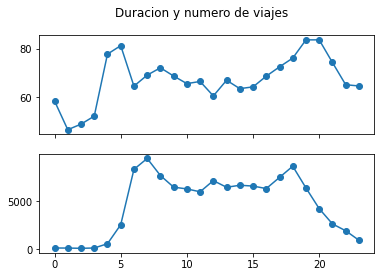

In [19]:
fig, axs = plt.subplots(2, sharex = True)
fig.suptitle('Duracion y numero de viajes')
axs[0].plot(horas, dur_media, 'o', linestyle = '-')
axs[1].plot(horas, num_viajes, 'o', linestyle = '-')


Basicamente todas estas cantidades siguen mas o menos el mismo tipo de estructura de horas pico y valle, podria concluirse que esta dinamica es la que rige la estructura de la movilidad de bogota. Para el caso particular de la duracion promedio de los viajes, se ve que las horas mas congestionadas son las horas pico, pero para este caso la hora pico parce desplazarse, como se ve, los viajes que se hacen entre 4 y 5 de la mañana duran muchisimo, al igual que los hechos entre 7 y 8 de la noche, como si los picos se hubieran movido a los extremos. Esto quiere decir que los pocos viajes que se hacen a las 4 y a las 5, estos duran un monton, pero tocaria ver de donde a donde son estos viajes y normalizarlos de mas que por la distancia, o ver si se dan fenomenos de congestion locales, de igual manera a las 8 de la noche ya bajo el numero de viajes que se hacen, peeeroooooo los que se estan haciendo duran muchiiisiiiimoooooo.

Se dan fenomenos muy curiosos, por ejemplo a las 6 de la mañana esta viajando un jurgo de gente, peeeroooo la duracion de los viajes no es tan grande, se va de pa abajo, incluso a las 7 de la mañana, en donde esta el maximo de viajes, la duracion de los viajes es de un poco mas de una hora. 

Un analisis completo de esto vendria cuando se tengan las distancias geograficas (mas o menos XD) porque estoy cerca, pero aun no se ve la congestion 

## Analisis de la distancia y velocidad

En esta parte se analisa la distancia  de los viajes

In [4]:
great_df['distancia'].agg('average')

5.554890850142206

In [4]:
df_v = great_df[(great_df['duracion'] > 0) & (great_df['distancia'] > 0)]

In [5]:
df_v['velocidad'] = 60.0*df_v['distancia']/df_v['duracion']
df_v['velocidad'].agg('average')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


20.7623652819721

La distancia promedio de viaje en Bogota y Soacha es de $5.5$ kilometros entre los centroidaes de las ZATS, y la velocidad promedio de los viajes en la ciudad es de 20.75 km/h 

In [7]:
# Distribucion de las distancias de viaje (proceso demorado)
distancia = np.asarray(great_df[great_df['distancia'] > 0]['distancia'])
distancia_x, distancia_y = count(distancia) 
yd_normal = distancia_y/sum(distancia_y)
dis_newman = newman(yd_normal)

In [6]:
vel = np.asarray(df_v['velocidad'])
vel_x, vel_y = count(vel) 
vel_normal = vel_y/sum(vel_y)
vel_newman = newman(vel_normal)

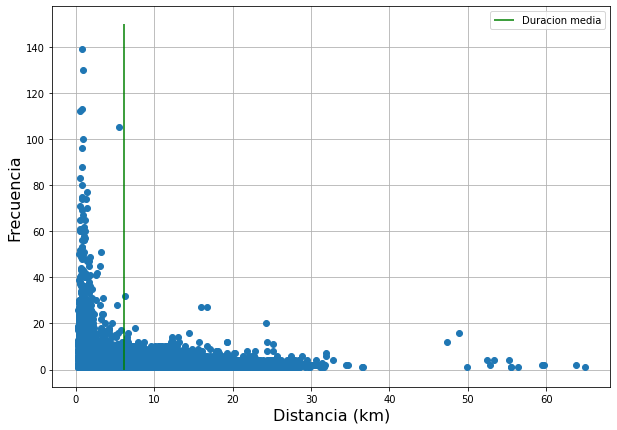

In [12]:
plt.figure(figsize = (10,7))
plt.plot(distancia_x, distancia_y, 'o')
plt.xlabel('Distancia (km)', fontsize = 16)
plt.ylabel('Frecuencia', fontsize = 16)
plt.vlines(np.mean(distancia), 0, 150, color = 'g',label = 'Duracion media')
plt.legend()
plt.grid()

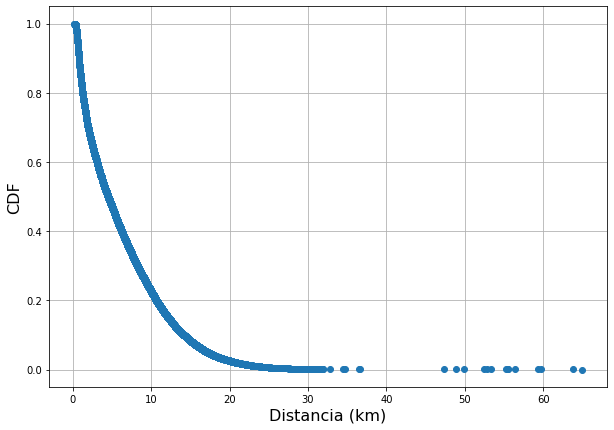

In [17]:
plt.figure(figsize = (10,7))
plt.plot(distancia_x, dis_newman, 'o')
plt.xlabel('Distancia (km)', fontsize = 16)
plt.ylabel('CDF', fontsize = 16)
#plt.vlines(np.mean(distancia), 0, 0.0015, color = 'g',label = 'Duracion media')
#plt.legend()
plt.grid()

Es impresionante como cambian las distribuciones cuando se aplica el metodo de Newman, en donde al parecer, es una ley exponencial, con una cola que tal ves sea una ley de potencias, peeerooooo parece muy loco que que se den distancias de mas de 40 km de distancia, con lo cual se podria filtrar. 
Bueno, estos viajes de mas de 40 kilometros son de sumapaz a cualquier parte, lo cual tiene mucho sentido, son 53 viajes registrados en esta zona.

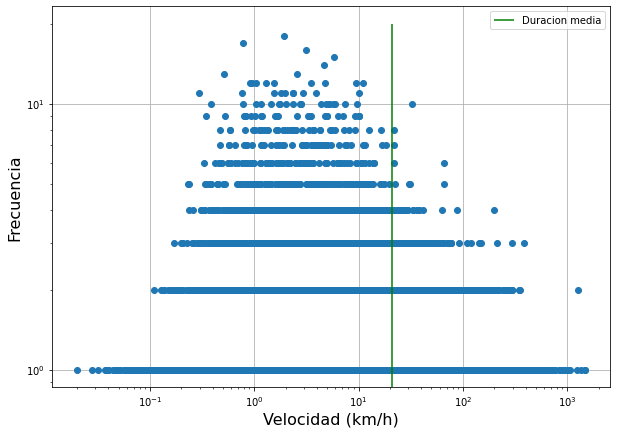

In [9]:
plt.figure(figsize = (10,7))
plt.loglog(vel_x, vel_y, 'o')
plt.xlabel('Velocidad (km/h)', fontsize = 16)
plt.ylabel('Frecuencia', fontsize = 16)
plt.vlines(np.mean(vel), 0, 20, color = 'g',label = 'Duracion media')
plt.legend()
plt.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


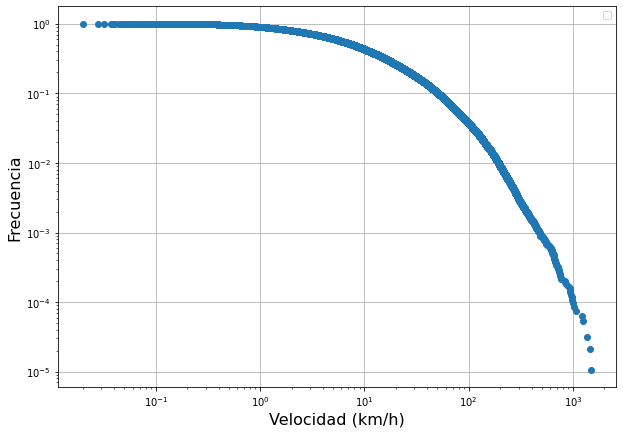

In [20]:
plt.figure(figsize = (10,7))
plt.loglog(vel_x, vel_newman, 'o')
plt.xlabel('Velocidad (km/h)', fontsize = 16)
plt.ylabel('Frecuencia', fontsize = 16)
#plt.vlines(np.mean(vel), 0, 1, color = 'g',label = 'Duracion media')
plt.legend()
plt.grid()

In [18]:
df_v[df_v['velocidad'] > 90][['zat_origen', 'zat_destino', 'duracion', 'distancia', 'velocidad', 'modo_principal', 'hora_inicio_viaje', 'hora_llegada']]

,zat_origen,zat_destino,duracion,distancia,velocidad,modo_principal,hora_inicio_viaje,hora_llegada
3,477.0,13.0,5,18.682519,224.190227,A pie,06:20:00,06:25:00
24,755.0,13.0,4,31.667393,475.010895,SITP Zonal,05:50:00,05:54:00
31,1.0,456.0,5,21.842136,262.105635,TransMilenio,06:25:00,06:30:00
34,477.0,1.0,10,22.006954,132.041727,TransMilenio,11:30:00,11:40:00
40,1.0,504.0,10,23.363824,140.182945,TransMilenio,11:00:00,11:10:00
...,...,...,...,...,...,...,...,...
101801,772.0,783.0,3,5.115352,102.307030,A pie,09:30:00,09:33:00
102307,774.0,781.0,1,3.018799,181.127914,A pie,01:03:00,01:04:00
103328,776.0,770.0,1,2.308458,138.507480,A pie,16:00:00,16:01:00
103640,773.0,774.0,1,2.463618,147.817059,A pie,09:20:00,09:21:00


Maldita sea esta gente no sabe llenar una maldita encuesta, como se va a demorar uno 4 minutos entre usme y el codito >:v, y a parte en un hijueputa sitp >:v, toca es coger un avion pa poder hacer eso maldita sea >:v

Vamos a ver la distancia promedio en funcion de la hora.

In [21]:
df_dis_vel = df_v[['hora_inicio_viaje', 'hora_llegada', 'distancia', 'velocidad']]
df_dis_vel = df_dis_vel[df_dis_vel['distancia'] > 0]
df_dis_vel['hora_inicio_viaje'] = to_time(df_dis_vel['hora_inicio_viaje'])
df_dis_vel['hora_llegada'] = to_time(df_dis_vel['hora_llegada'])

In [22]:
horas = []
dis_media = []
dis_viajes = []
vel_media = []
hora = datetime.time(0, 0)
hora_out = datetime.time(22, 0)
hora_in = datetime.time(2,0)
df = df_dis_vel[(df_dis_vel['hora_inicio_viaje'] >= hora_out) & 
             (df_dis_vel['hora_llegada'] <= hora_in) &
             (df_dis_vel['hora_inicio_viaje'] <= datetime.time(23, 59)) & 
             (df_dis_vel['hora_llegada'] >= hora)]
dis_media.append(df['distancia'].agg('average'))
horas.append(0)
dis_viajes.append(len(df))
vel_media.append(df['velocidad'].agg('average'))
for i in range(1,24):
    hora = datetime.time(i, 0)
    df = df_dis_vel[(df_dis_vel['hora_inicio_viaje'] <= hora) & (df_dis_vel['hora_llegada'] >= hora)]
    dis_media.append(df['distancia'].agg('average'))
    horas.append(i)
    dis_viajes.append(len(df))
    vel_media.append(df['velocidad'].agg('average'))

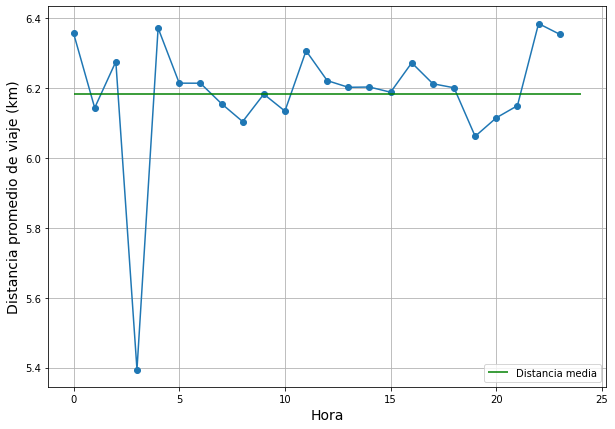

In [43]:
plt.figure(figsize = (10, 7))
plt.plot(horas, dis_media, 'o', linestyle = '-')
plt.hlines(np.mean(dis_media), 0, 24, color = 'g',label = 'Distancia media')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Distancia promedio de viaje (km)', fontsize = 14)
plt.legend()
plt.grid()

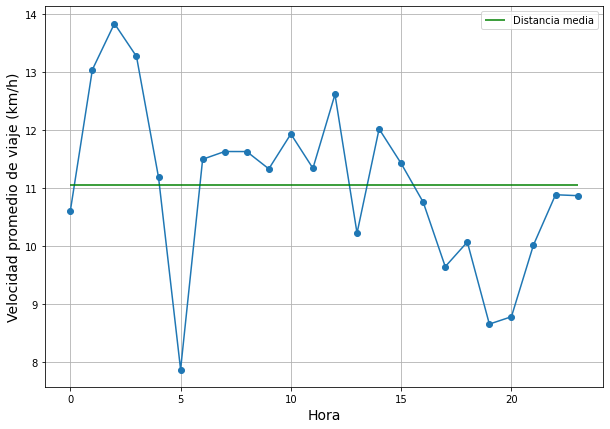

In [27]:
plt.figure(figsize = (10, 7))
plt.plot(horas, vel_media, 'o', linestyle = '-')
plt.hlines(np.mean(vel_media), 0, 23, color = 'g',label = 'Distancia media')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Velocidad promedio de viaje (km/h)', fontsize = 14)
plt.legend()
plt.grid()

In [27]:
great_df[great_df['distancia'] < 5.5][['zat_origen', 'zat_destino', 'duracion', 'distancia']]

,zat_origen,zat_destino,duracion,distancia
4,13.0,14.0,480,0.672520
5,13.0,14.0,10,0.672520
6,14.0,13.0,5,0.672520
7,14.0,13.0,118,0.672520
8,13.0,14.0,30,0.672520
...,...,...,...,...
104675,765.0,765.0,30,0.000000
104676,765.0,765.0,70,0.000000
104677,765.0,766.0,75,0.824004
104678,774.0,765.0,6,0.720240


La distancia dependiendo de la hora no cambia demasiado en funcion de la hora del dia de al rededor de $6.2$ kilometros.

In [39]:
td = []
for i in range(len(dis_media)):
    rho = dur_media[i]/dis_media[i]
    td.append(rho)
v = []
for i in range(len(dis_media)):
    rho = 60.0*dis_media[i]/dur_media[i]
    v.append(rho)

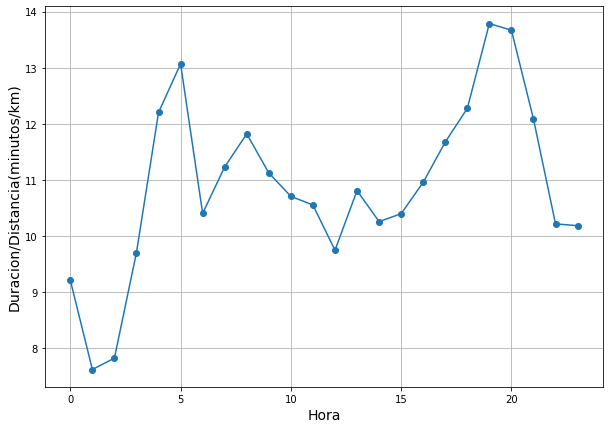

In [40]:
plt.figure(figsize = (10, 7))
plt.plot(horas, td, 'o', linestyle = '-')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Duracion/Distancia(minutos/km)', fontsize = 14)
plt.grid()

Pues esta parece ser mi medida de congestion, la cantidad $dur/dis$ me da razon del comportamiento de la ciudad 

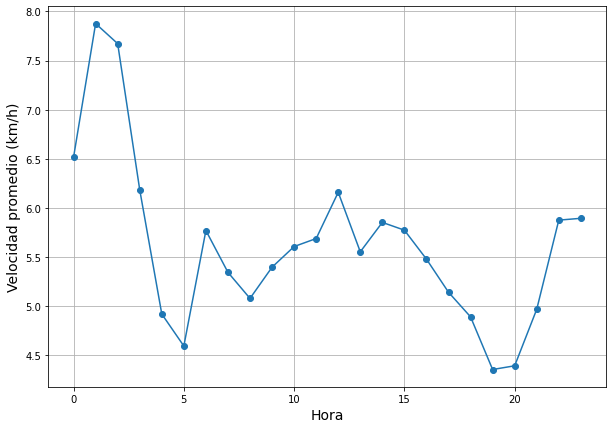

In [41]:
plt.figure(figsize = (10, 7))
plt.plot(horas, v, 'o', linestyle = '-')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Velocidad promedio (km/h)', fontsize = 14)
plt.grid()

La velocidad media en toda la red de bogota es muy muy baja, va entre los 4.2 y los casi 8 km por hora, esto es para TOOODOOOS los medios de transporte, esto deberia hacerse para todos los medios de transporte.
El siguiente paso es sacar estas medidas para todos los estratos y medios de transporte, al menos los mas relevantes como carro, transmi, cicla, bus, sitp, moto.

Yo infiero que los bajos valores a las 4 y 5 de la mañana son fenomenos zonales en donde la mayor parte de las personas que estan viajando en la red estan trancadas en zonas muy especificas, como cuando uno ve trancones en soacha a las 4 de la mañana. 

## Duracion, distancia y congestion segun el estrato

In [28]:
# Dataframes para la duracion de viajes en funcion del estrato y la hora

df_dur1 = df_v[df_v['p5_estrato'] == 1][['hora_inicio_viaje', 'hora_llegada', 'duracion', 'distancia', 'velocidad']]
df_dur1 = df_dur1[df_dur1['duracion'] <= 200]
df_dur1 = df_dur1[df_dur1['distancia'] > 0]
df_dur1['hora_inicio_viaje'] = to_time(df_dur1['hora_inicio_viaje'])
df_dur1['hora_llegada'] = to_time(df_dur1['hora_llegada'])

df_dur2 = df_v[df_v['p5_estrato'] == 2][['hora_inicio_viaje', 'hora_llegada', 'duracion','distancia', 'velocidad']]
df_dur2 = df_dur2[df_dur2['duracion'] <= 200]
df_dur2 = df_dur2[df_dur2['distancia'] > 0]
df_dur2['hora_inicio_viaje'] = to_time(df_dur2['hora_inicio_viaje'])
df_dur2['hora_llegada'] = to_time(df_dur2['hora_llegada'])

df_dur3 = df_v[df_v['p5_estrato'] == 3][['hora_inicio_viaje', 'hora_llegada', 'duracion', 'distancia', 'velocidad']]
df_dur3 = df_dur3[df_dur3['duracion'] <= 200]
df_dur3 = df_dur3[df_dur3['distancia'] > 0]
df_dur3['hora_inicio_viaje'] = to_time(df_dur3['hora_inicio_viaje'])
df_dur3['hora_llegada'] = to_time(df_dur3['hora_llegada'])

df_dur4 = df_v[df_v['p5_estrato'] == 4][['hora_inicio_viaje', 'hora_llegada', 'duracion', 'distancia', 'velocidad']]
df_dur4 = df_dur4[df_dur4['duracion'] <= 200]
df_dur4 = df_dur4[df_dur4['distancia'] > 0]
df_dur4['hora_inicio_viaje'] = to_time(df_dur4['hora_inicio_viaje'])
df_dur4['hora_llegada'] = to_time(df_dur4['hora_llegada'])

df_dur5 = df_v[df_v['p5_estrato'] == 5][['hora_inicio_viaje', 'hora_llegada', 'duracion', 'distancia', 'velocidad']]
df_dur5 = df_dur5[df_dur5['duracion'] <= 200]
df_dur5 = df_dur5[df_dur5['distancia'] > 0]
df_dur5['hora_inicio_viaje'] = to_time(df_dur5['hora_inicio_viaje'])
df_dur5['hora_llegada'] = to_time(df_dur5['hora_llegada'])

df_dur6 = df_v[df_v['p5_estrato'] == 6][['hora_inicio_viaje', 'hora_llegada', 'duracion', 'distancia', 'velocidad']]
df_dur6 = df_dur6[df_dur6['duracion'] <= 200]
df_dur6 = df_dur6[df_dur6['distancia'] > 0]
df_dur6['hora_inicio_viaje'] = to_time(df_dur6['hora_inicio_viaje'])
df_dur6['hora_llegada'] = to_time(df_dur6['hora_llegada'])

In [29]:
def duracion_media(df_duracion):
    horas = []
    dur_media = []
    viajes = []
    dist_media = []
    vel_media = []
    hora = datetime.time(0, 0)
    hora_out = datetime.time(22, 0)
    hora_in = datetime.time(2,0)
    df = df_duracion[(df_duracion['hora_inicio_viaje'] >= hora_out) & 
                     (df_duracion['hora_llegada'] <= hora_in) &
                     (df_duracion['hora_inicio_viaje'] <= datetime.time(23, 59)) & 
                     (df_duracion['hora_llegada'] >= hora)]
    dur_media.append(df['duracion'].agg('average'))
    dist_media.append(df['distancia'].agg('average'))
    horas.append(0)
    viajes.append(len(df))
    vel_media.append(df['velocidad'].agg('average'))
    for i in range(1,24):
        hora = datetime.time(i, 0)
        df = df_duracion[(df_duracion['hora_inicio_viaje'] <= hora) & (df_duracion['hora_llegada'] >= hora)]
        dur_media.append(df['duracion'].agg('average'))
        dist_media.append(df['distancia'].agg('average'))
        horas.append(i)
        viajes.append(len(df))
        vel_media.append(df['velocidad'].agg('average'))

    dur_media = np.asarray(dur_media)
    viajes = np.asarray(viajes)
    dist_media = np.asarray(dist_media)
    vel_media = np.asarray(vel_media)

    return horas, dur_media, viajes, dist_media, vel_media

In [30]:
horas1, dur_1, viajes_1, dist_1, vel_1 = duracion_media(df_dur1)
horas2, dur_2, viajes_2, dist_2, vel_2 = duracion_media(df_dur2)
horas3, dur_3, viajes_3, dist_3, vel_3 = duracion_media(df_dur3)
horas4, dur_4, viajes_4, dist_4, vel_4 = duracion_media(df_dur4)
horas5, dur_5, viajes_5, dist_5, vel_5 = duracion_media(df_dur5)
horas6, dur_6, viajes_6, dist_6, vel_6 = duracion_media(df_dur6)

In [61]:
horas_6 = []

for i in horas6:
    if i != 1:
        horas_6.append(i)

def eliminate(d_6):
    array = []
    for i in d_6:
        if i < d_6[1]:
            array.append(i)
    return array

def eliminate_vel(d_6):
    array = []
    for i in d_6:
        if i > d_6[1]:
            array.append(i)
    return array

dur6 = eliminate(dur_6)
dist6 = eliminate(dist_6)
vel6 = eliminate_vel(vel_6)

In [60]:
vel_6

array([10.65724148,  3.51833991,  4.06754514,  3.74307089,  8.42814327,
        4.72998871, 10.06298942, 12.70003332, 12.30752549, 10.51034378,
       10.92694562, 12.53724667, 15.48780634,  9.92304411, 13.26907611,
        8.76546674,  8.23758532,  9.31283227,  9.86902273,  7.02938331,
        6.54474629,  7.05197486, 10.73144512, 12.2804282 ])

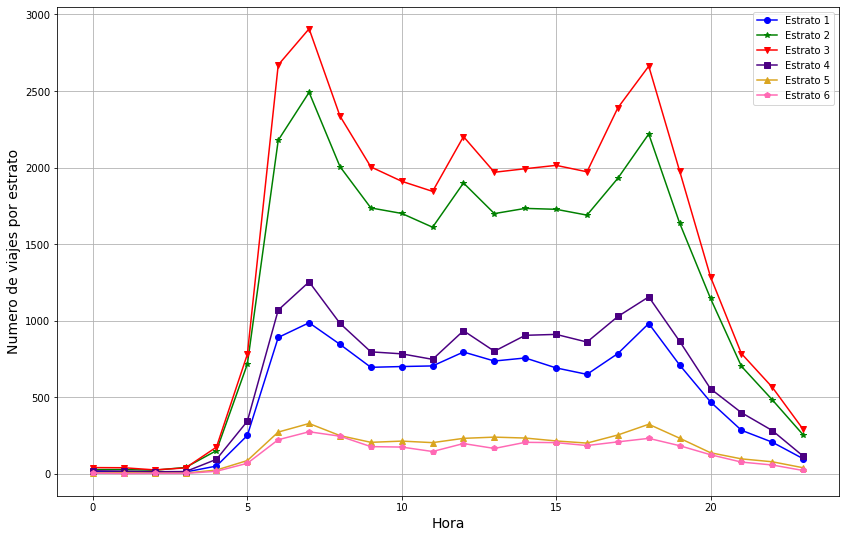

In [37]:
plt.figure(figsize = (14, 9))
plt.plot(horas1, viajes_1, 'o', linestyle = '-', color = 'b', label = 'Estrato 1')
plt.plot(horas2, viajes_2, '*', linestyle = '-', color = 'g', label = 'Estrato 2')
plt.plot(horas3, viajes_3, 'v', linestyle = '-', color = 'r', label = 'Estrato 3')
plt.plot(horas4, viajes_4, 's', linestyle = '-', color = 'indigo', label = 'Estrato 4')
plt.plot(horas5, viajes_5, '^', linestyle = '-', color = 'goldenrod', label = 'Estrato 5')
plt.plot(horas6, viajes_6, 'p', linestyle = '-', color = 'hotpink', label = 'Estrato 6')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Numero de viajes por estrato', fontsize = 14)
plt.legend()
plt.grid()

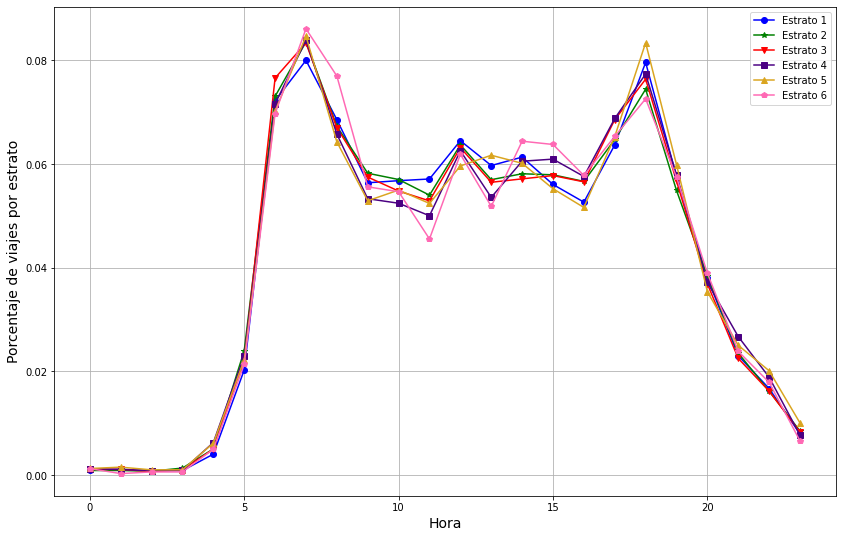

In [38]:
plt.figure(figsize = (14, 9))
plt.plot(horas1, viajes_1/sum(viajes_1), 'o', linestyle = '-', color = 'b', label = 'Estrato 1')
plt.plot(horas2, viajes_2/sum(viajes_2), '*', linestyle = '-', color = 'g', label = 'Estrato 2')
plt.plot(horas3, viajes_3/sum(viajes_3), 'v', linestyle = '-', color = 'r', label = 'Estrato 3')
plt.plot(horas4, viajes_4/sum(viajes_4), 's', linestyle = '-', color = 'indigo', label = 'Estrato 4')
plt.plot(horas5, viajes_5/sum(viajes_5), '^', linestyle = '-', color = 'goldenrod', label = 'Estrato 5')
plt.plot(horas6, viajes_6/sum(viajes_6), 'p', linestyle = '-', color = 'hotpink', label = 'Estrato 6')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Porcentaje de viajes por estrato', fontsize = 14)
plt.legend()
plt.grid()

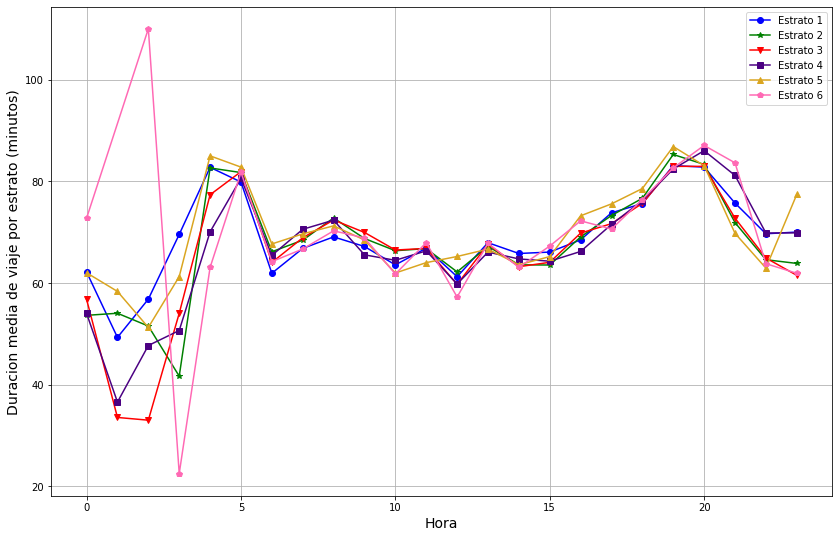

In [57]:
plt.figure(figsize = (14, 9))
plt.plot(horas1, dur_1, 'o', linestyle = '-', color = 'b', label = 'Estrato 1')
plt.plot(horas2, dur_2, '*', linestyle = '-', color = 'g', label = 'Estrato 2')
plt.plot(horas3, dur_3, 'v', linestyle = '-', color = 'r', label = 'Estrato 3')
plt.plot(horas4, dur_4, 's', linestyle = '-', color = 'indigo', label = 'Estrato 4')
plt.plot(horas5, dur_5, '^', linestyle = '-', color = 'goldenrod', label = 'Estrato 5')
plt.plot(horas_6, dur6, 'p', linestyle = '-', color = 'hotpink', label = 'Estrato 6')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Duracion media de viaje por estrato (minutos)', fontsize = 14)
plt.legend()
plt.grid()

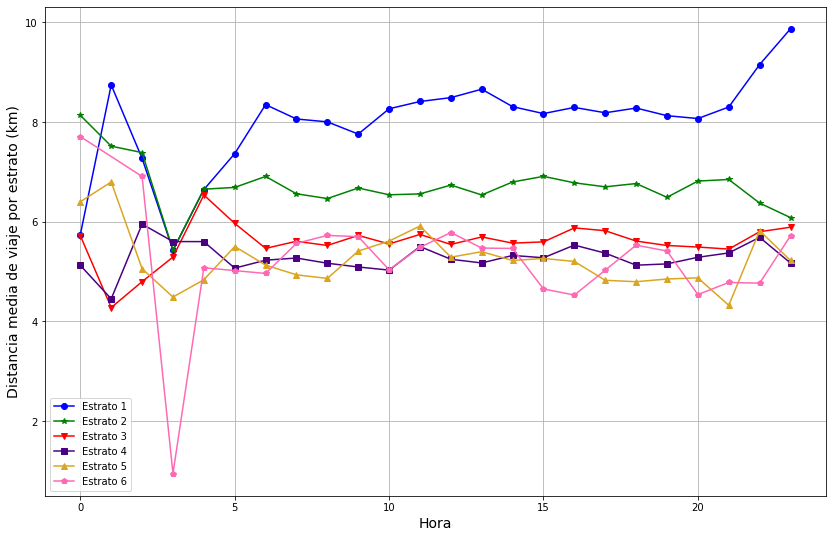

In [58]:
plt.figure(figsize = (14, 9))
plt.plot(horas1, dist_1, 'o', linestyle = '-', color = 'b', label = 'Estrato 1')
plt.plot(horas2, dist_2, '*', linestyle = '-', color = 'g', label = 'Estrato 2')
plt.plot(horas3, dist_3, 'v', linestyle = '-', color = 'r', label = 'Estrato 3')
plt.plot(horas4, dist_4, 's', linestyle = '-', color = 'indigo', label = 'Estrato 4')
plt.plot(horas5, dist_5, '^', linestyle = '-', color = 'goldenrod', label = 'Estrato 5')
plt.plot(horas_6, dist6, 'p', linestyle = '-', color = 'hotpink', label = 'Estrato 6')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Distancia media de viaje por estrato (km)', fontsize = 14)
plt.legend()
plt.grid()

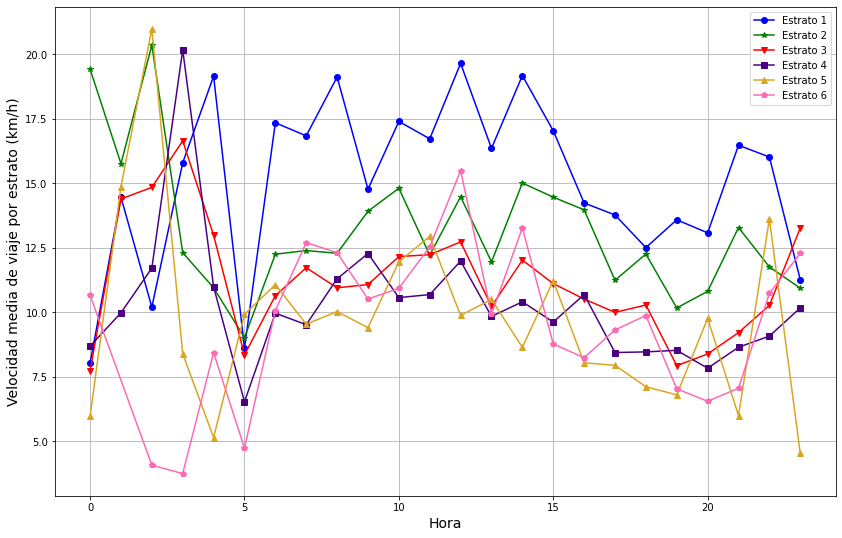

In [62]:
plt.figure(figsize = (14, 9))
plt.plot(horas1, vel_1, 'o', linestyle = '-', color = 'b', label = 'Estrato 1')
plt.plot(horas2, vel_2, '*', linestyle = '-', color = 'g', label = 'Estrato 2')
plt.plot(horas3, vel_3, 'v', linestyle = '-', color = 'r', label = 'Estrato 3')
plt.plot(horas4, vel_4, 's', linestyle = '-', color = 'indigo', label = 'Estrato 4')
plt.plot(horas5, vel_5, '^', linestyle = '-', color = 'goldenrod', label = 'Estrato 5')
plt.plot(horas_6, vel6, 'p', linestyle = '-', color = 'hotpink', label = 'Estrato 6')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Velocidad media de viaje por estrato (km/h)', fontsize = 14)
plt.legend()
plt.grid()

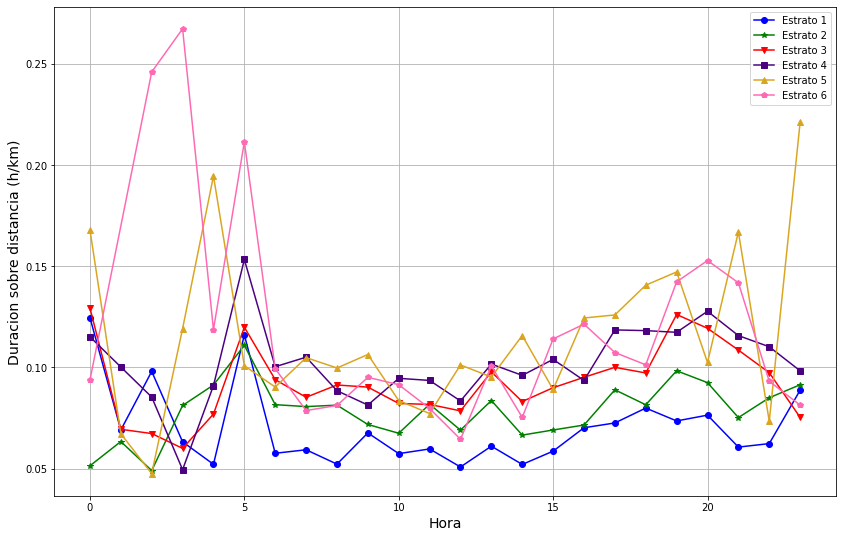

In [67]:
plt.figure(figsize = (14, 9))
plt.plot(horas1, 1/vel_1, 'o', linestyle = '-', color = 'b', label = 'Estrato 1')
plt.plot(horas2, 1/vel_2, '*', linestyle = '-', color = 'g', label = 'Estrato 2')
plt.plot(horas3, 1/vel_3, 'v', linestyle = '-', color = 'r', label = 'Estrato 3')
plt.plot(horas4, 1/vel_4, 's', linestyle = '-', color = 'indigo', label = 'Estrato 4')
plt.plot(horas5, 1/vel_5, '^', linestyle = '-', color = 'goldenrod', label = 'Estrato 5')
plt.plot(horas_6, 1/np.asarray(vel6), 'p', linestyle = '-', color = 'hotpink', label = 'Estrato 6')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Duracion sobre distancia (h/km)', fontsize = 14)
plt.legend()
plt.grid()

In [150]:
# Duracion sobre distancia como medida de congestion
td_1 = dur_1/dist_1
td_2 = dur_2/dist_2
td_3 = dur_3/dist_3
td_4 = dur_4/dist_4
td_5 = dur_5/dist_5
td_6 = dur_6/dist_6

In [154]:
# Velocidad media por estrato en km/h
v_1 = 60.0*dist_1/dur_1
v_2 = 60.0*dist_2/dur_2
v_3 = 60.0*dist_3/dur_3
v_4 = 60.0*dist_4/dur_4
v_5 = 60.0*dist_5/dur_5
v_6 = 60.0*dist_6/dur_6

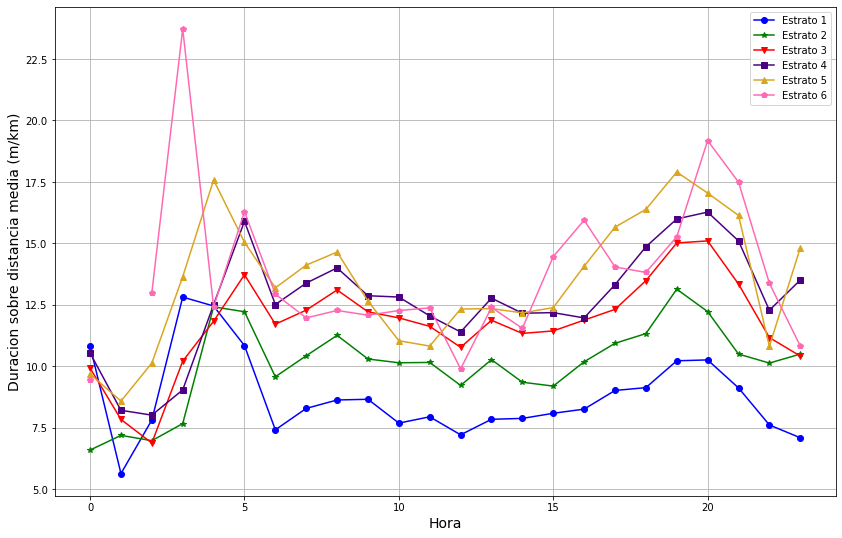

In [151]:
plt.figure(figsize = (14, 9))
plt.plot(horas1, td_1, 'o', linestyle = '-', color = 'b', label = 'Estrato 1')
plt.plot(horas2, td_2, '*', linestyle = '-', color = 'g', label = 'Estrato 2')
plt.plot(horas3, td_3, 'v', linestyle = '-', color = 'r', label = 'Estrato 3')
plt.plot(horas4, td_4, 's', linestyle = '-', color = 'indigo', label = 'Estrato 4')
plt.plot(horas5, td_5, '^', linestyle = '-', color = 'goldenrod', label = 'Estrato 5')
plt.plot(horas6, td_6, 'p', linestyle = '-', color = 'hotpink', label = 'Estrato 6')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Duracion sobre distancia media (m/km)', fontsize = 14)
plt.legend()
plt.grid()

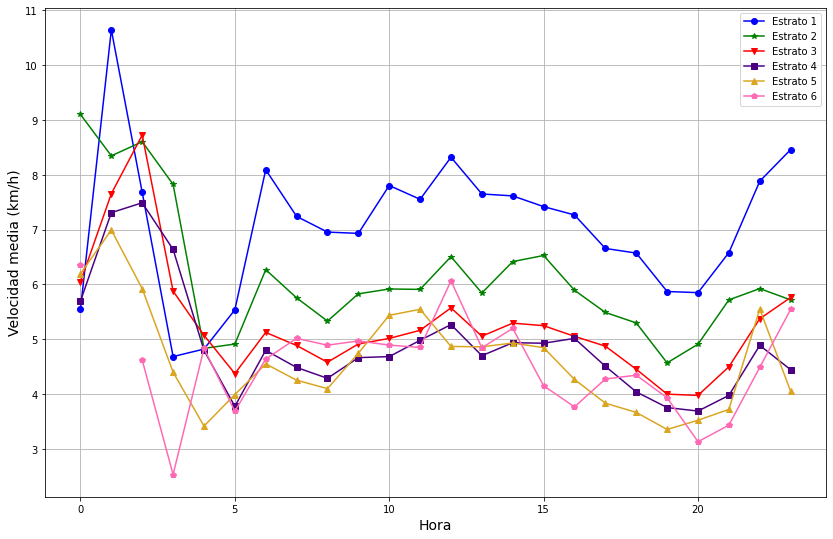

In [155]:
plt.figure(figsize = (14, 9))
plt.plot(horas1, v_1, 'o', linestyle = '-', color = 'b', label = 'Estrato 1')
plt.plot(horas2, v_2, '*', linestyle = '-', color = 'g', label = 'Estrato 2')
plt.plot(horas3, v_3, 'v', linestyle = '-', color = 'r', label = 'Estrato 3')
plt.plot(horas4, v_4, 's', linestyle = '-', color = 'indigo', label = 'Estrato 4')
plt.plot(horas5, v_5, '^', linestyle = '-', color = 'goldenrod', label = 'Estrato 5')
plt.plot(horas6, v_6, 'p', linestyle = '-', color = 'hotpink', label = 'Estrato 6')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Velocidad media (km/h)', fontsize = 14)
plt.legend()
plt.grid()

## Estudio por modo de transporte

In [33]:
df_transmi = df_v[df_v['modo_principal'] == 'TransMilenio'][['hora_inicio_viaje', 'hora_llegada', 'duracion', 'distancia', 'velocidad']]
df_transmi = df_transmi[df_transmi['duracion'] <= 200]
df_transmi = df_transmi[df_transmi['distancia'] > 0]
df_transmi['hora_inicio_viaje'] = to_time(df_transmi['hora_inicio_viaje'])
df_transmi['hora_llegada'] = to_time(df_transmi['hora_llegada'])

df_carro = df_v[df_v['modo_principal'] == 'Auto'][['hora_inicio_viaje', 'hora_llegada', 'duracion','distancia', 'velocidad']]
df_carro = df_carro[df_carro['duracion'] <= 200]
df_carro = df_carro[df_carro['distancia'] > 0]
df_carro['hora_inicio_viaje'] = to_time(df_carro['hora_inicio_viaje'])
df_carro['hora_llegada'] = to_time(df_carro['hora_llegada'])

df_sitp = df_v[df_v['modo_principal'] == 'SITP Zonal'][['hora_inicio_viaje', 'hora_llegada', 'duracion', 'distancia', 'velocidad']]
df_sitp = df_sitp[df_sitp['duracion'] <= 200]
df_sitp = df_sitp[df_sitp['distancia'] > 0]
df_sitp['hora_inicio_viaje'] = to_time(df_sitp['hora_inicio_viaje'])
df_sitp['hora_llegada'] = to_time(df_sitp['hora_llegada'])

df_bici = df_v[df_v['modo_principal'] == 'Bicicleta'][['hora_inicio_viaje', 'hora_llegada', 'duracion', 'distancia', 'velocidad']]
df_bici = df_bici[df_bici['duracion'] <= 200]
df_bici = df_bici[df_bici['distancia'] > 0]
df_bici['hora_inicio_viaje'] = to_time(df_bici['hora_inicio_viaje'])
df_bici['hora_llegada'] = to_time(df_bici['hora_llegada'])

df_bus = df_v[df_v['modo_principal'] == 'SITP Provisional'][['hora_inicio_viaje', 'hora_llegada', 'duracion', 'distancia', 'velocidad']]
df_bus = df_bus[df_bus['duracion'] <= 200]
df_bus = df_bus[df_bus['distancia'] > 0]
df_bus['hora_inicio_viaje'] = to_time(df_bus['hora_inicio_viaje'])
df_bus['hora_llegada'] = to_time(df_bus['hora_llegada'])

df_moto = df_v[df_v['modo_principal'] == 'Moto'][['hora_inicio_viaje', 'hora_llegada', 'duracion', 'distancia', 'velocidad']]
df_moto = df_moto[df_moto['duracion'] <= 200]
df_moto = df_moto[df_moto['distancia'] > 0]
df_moto['hora_inicio_viaje'] = to_time(df_moto['hora_inicio_viaje'])
df_moto['hora_llegada'] = to_time(df_moto['hora_llegada'])

In [34]:
horast, dur_t, viajes_t, dist_t, vel_t = duracion_media(df_transmi)
horasc, dur_c, viajes_c, dist_c, vel_c = duracion_media(df_carro)
horass, dur_s, viajes_s, dist_s, vel_s = duracion_media(df_sitp)
horasb, dur_b, viajes_b, dist_b, vel_b = duracion_media(df_bici)
horasbus, dur_bus, viajes_bus, dist_bus, vel_bus = duracion_media(df_bus)
horasm, dur_m, viajes_m, dist_m, vel_m = duracion_media(df_moto)

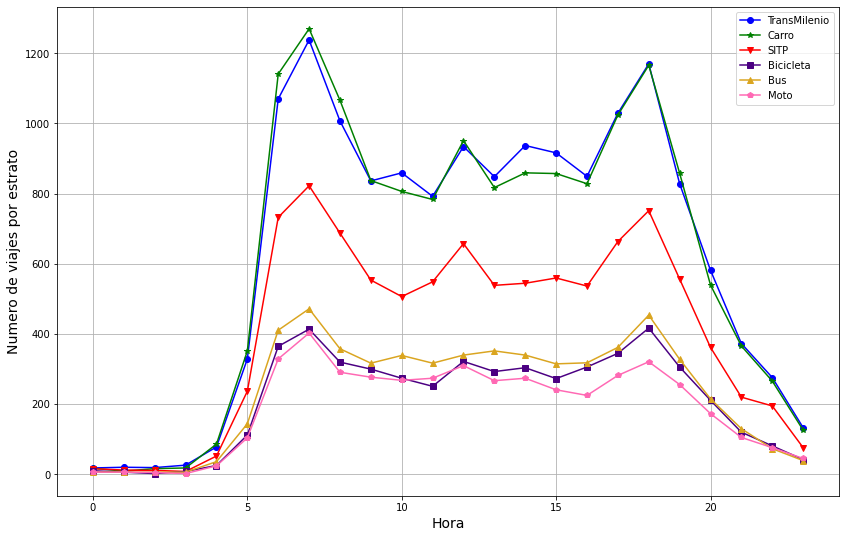

In [160]:
plt.figure(figsize = (14, 9))
plt.plot(horast, viajes_t, 'o', linestyle = '-', color = 'b', label = 'TransMilenio')
plt.plot(horasc, viajes_c, '*', linestyle = '-', color = 'g', label = 'Carro')
plt.plot(horass, viajes_s, 'v', linestyle = '-', color = 'r', label = 'SITP')
plt.plot(horasb, viajes_b, 's', linestyle = '-', color = 'indigo', label = 'Bicicleta')
plt.plot(horasbus, viajes_bus, '^', linestyle = '-', color = 'goldenrod', label = 'Bus')
plt.plot(horasm, viajes_m, 'p', linestyle = '-', color = 'hotpink', label = 'Moto')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Numero de viajes por estrato', fontsize = 14)
plt.legend()
plt.grid()

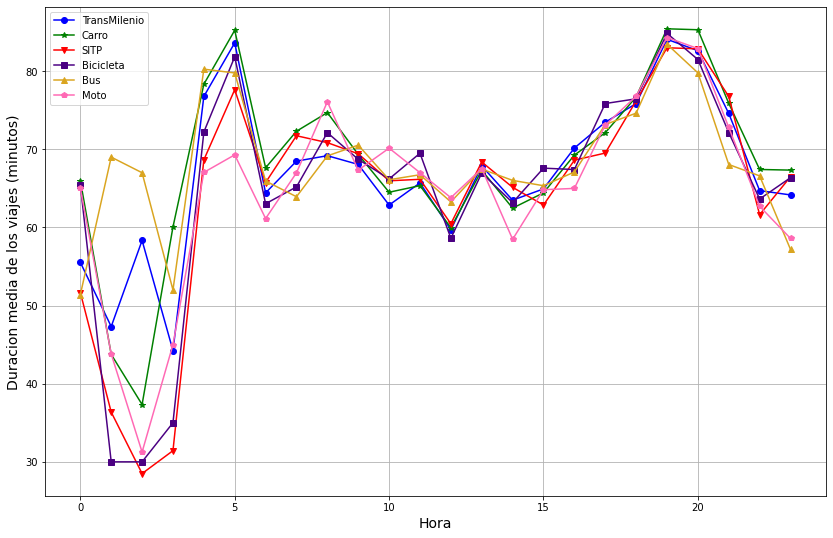

In [162]:
plt.figure(figsize = (14, 9))
plt.plot(horast, dur_t, 'o', linestyle = '-', color = 'b', label = 'TransMilenio')
plt.plot(horasc, dur_c, '*', linestyle = '-', color = 'g', label = 'Carro')
plt.plot(horass, dur_s, 'v', linestyle = '-', color = 'r', label = 'SITP')
plt.plot(horasb, dur_b, 's', linestyle = '-', color = 'indigo', label = 'Bicicleta')
plt.plot(horasbus, dur_bus, '^', linestyle = '-', color = 'goldenrod', label = 'Bus')
plt.plot(horasm, dur_m, 'p', linestyle = '-', color = 'hotpink', label = 'Moto')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Duracion media de los viajes (minutos)', fontsize = 14)
plt.legend()
plt.grid()

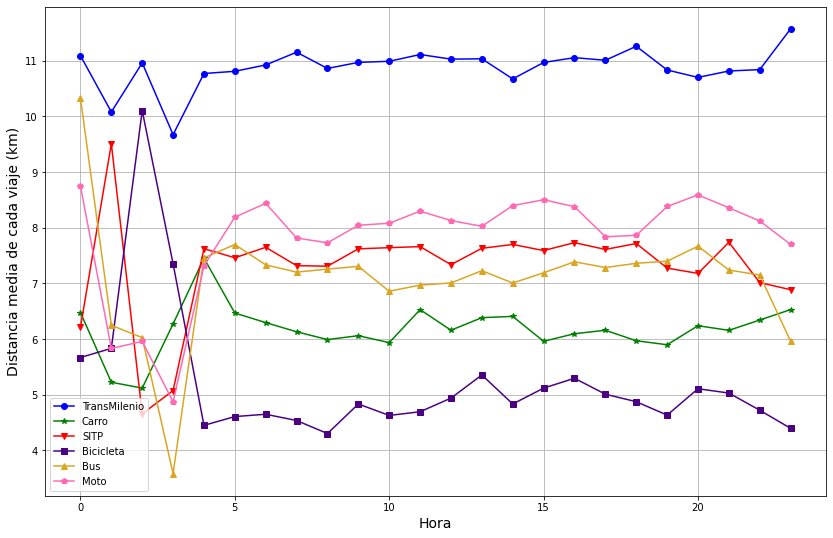

In [164]:
plt.figure(figsize = (14, 9))
plt.plot(horast, dist_t, 'o', linestyle = '-', color = 'b', label = 'TransMilenio')
plt.plot(horasc, dist_c, '*', linestyle = '-', color = 'g', label = 'Carro')
plt.plot(horass, dist_s, 'v', linestyle = '-', color = 'r', label = 'SITP')
plt.plot(horasb, dist_b, 's', linestyle = '-', color = 'indigo', label = 'Bicicleta')
plt.plot(horasbus, dist_bus, '^', linestyle = '-', color = 'goldenrod', label = 'Bus')
plt.plot(horasm, dist_m, 'p', linestyle = '-', color = 'hotpink', label = 'Moto')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Distancia media de cada viaje (km)', fontsize = 14)
plt.legend()
plt.grid()

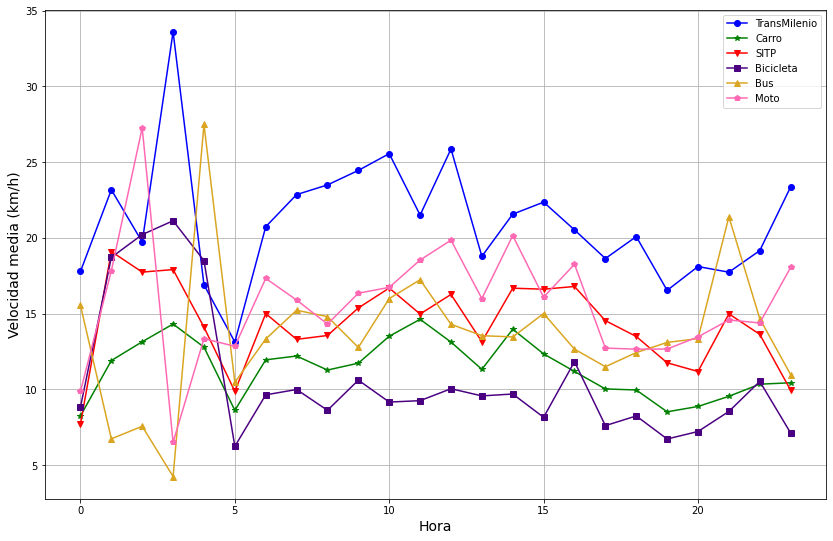

In [35]:
plt.figure(figsize = (14, 9))
plt.plot(horast, vel_t, 'o', linestyle = '-', color = 'b', label = 'TransMilenio')
plt.plot(horasc, vel_c, '*', linestyle = '-', color = 'g', label = 'Carro')
plt.plot(horass, vel_s, 'v', linestyle = '-', color = 'r', label = 'SITP')
plt.plot(horasb, vel_b, 's', linestyle = '-', color = 'indigo', label = 'Bicicleta')
plt.plot(horasbus, vel_bus, '^', linestyle = '-', color = 'goldenrod', label = 'Bus')
plt.plot(horasm, vel_m, 'p', linestyle = '-', color = 'hotpink', label = 'Moto')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Velocidad media (km/h)', fontsize = 14)
plt.legend()
plt.grid()

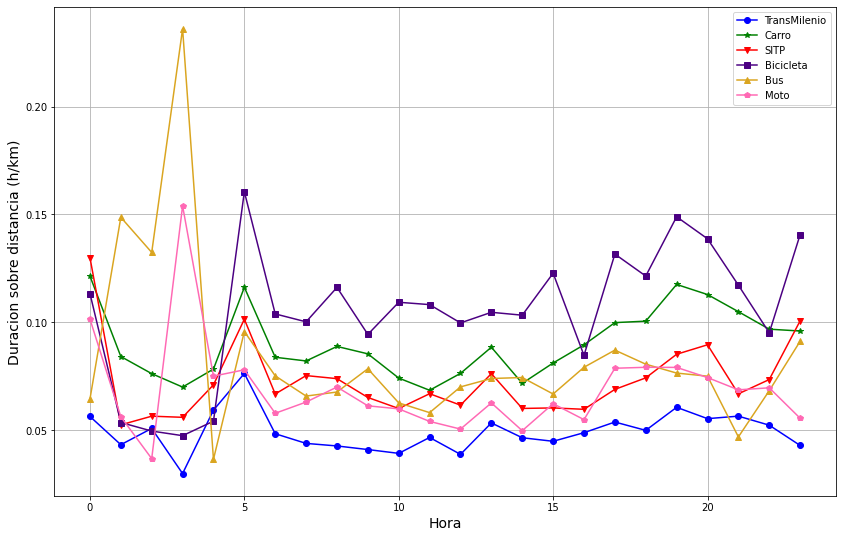

In [36]:
plt.figure(figsize = (14, 9))
plt.plot(horast, 1/vel_t, 'o', linestyle = '-', color = 'b', label = 'TransMilenio')
plt.plot(horasc, 1/vel_c, '*', linestyle = '-', color = 'g', label = 'Carro')
plt.plot(horass, 1/vel_s, 'v', linestyle = '-', color = 'r', label = 'SITP')
plt.plot(horasb, 1/vel_b, 's', linestyle = '-', color = 'indigo', label = 'Bicicleta')
plt.plot(horasbus, 1/vel_bus, '^', linestyle = '-', color = 'goldenrod', label = 'Bus')
plt.plot(horasm, 1/vel_m, 'p', linestyle = '-', color = 'hotpink', label = 'Moto')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Duracion sobre distancia (h/km)', fontsize = 14)
plt.legend()
plt.grid()

In [166]:
# Duracion sobre distancia
td_t = dur_t/dist_t
td_c = dur_c/dist_c
td_s = dur_s/dist_s
td_b = dur_b/dist_b
td_bus = dur_bus/dist_bus
td_m = dur_m/dist_m

# Velocidad media en km/h 
v_t = 60.0*dist_t/dur_t
v_c = 60.0*dist_c/dur_c
v_s = 60.0*dist_s/dur_s
v_b = 60.0*dist_b/dur_b
v_bus = 60.0*dist_bus/dur_bus
v_m = 60.0*dist_m/dur_m

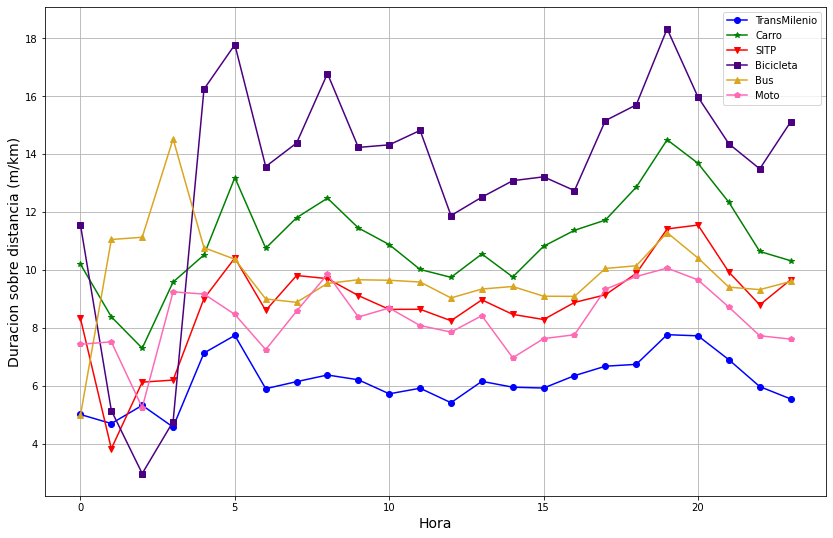

In [167]:
plt.figure(figsize = (14, 9))
plt.plot(horast, td_t, 'o', linestyle = '-', color = 'b', label = 'TransMilenio')
plt.plot(horasc, td_c, '*', linestyle = '-', color = 'g', label = 'Carro')
plt.plot(horass, td_s, 'v', linestyle = '-', color = 'r', label = 'SITP')
plt.plot(horasb, td_b, 's', linestyle = '-', color = 'indigo', label = 'Bicicleta')
plt.plot(horasbus, td_bus, '^', linestyle = '-', color = 'goldenrod', label = 'Bus')
plt.plot(horasm, td_m, 'p', linestyle = '-', color = 'hotpink', label = 'Moto')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Duracion sobre distancia (m/km)', fontsize = 14)
plt.legend()
plt.grid()

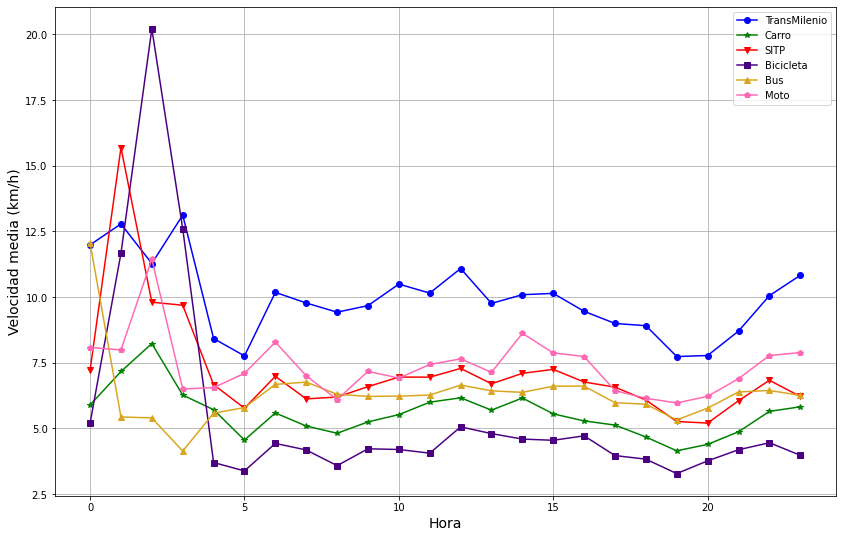

In [168]:
plt.figure(figsize = (14, 9))
plt.plot(horast, v_t, 'o', linestyle = '-', color = 'b', label = 'TransMilenio')
plt.plot(horasc, v_c, '*', linestyle = '-', color = 'g', label = 'Carro')
plt.plot(horass, v_s, 'v', linestyle = '-', color = 'r', label = 'SITP')
plt.plot(horasb, v_b, 's', linestyle = '-', color = 'indigo', label = 'Bicicleta')
plt.plot(horasbus, v_bus, '^', linestyle = '-', color = 'goldenrod', label = 'Bus')
plt.plot(horasm, v_m, 'p', linestyle = '-', color = 'hotpink', label = 'Moto')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Velocidad media (km/h)', fontsize = 14)
plt.legend()
plt.grid()

In [70]:
great_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'id_hogar', 'Estado', 'Utam', 'Sector', 'Seccion', 'Manzana',
       'p5_fecha', 'p7_Barrio_vivienda', 'Latitud', 'Longitud', 'zat_hogar',
       'p5_estrato', 'p6_hogares_vivienda', 'p7_total_personas',
       'p8_mayores_cinco_anios', 'id_rango_ingresos', 'vivienda', 'Factor',
       'municipio', 'localidad', 'id_persona', 'id_viaje', 'fecha',
       'lugar_origen', 'zat_origen', 'p17_Id_motivo_viaje', 'p17_otro_motivo',
       'hora_inicio_viaje', 'p28_lugar_destino', 'zat_destino',
       'p29_id_municipio', 'p30_camino_cuadras', 'p30_camino_minutos',
       'hora_llegada', 'p32_lunes', 'p32_martes', 'p32_miercoles',
       'p32_jueves', 'p32_viernes', 'p32_sabado', 'p32_domingo',
       'p32_ocasional', 'p36_hora_salida', 'f_exp', 'mun_origen',
       'mun_destino', 'utam_origen', 'utam_destino', 'modo_principal',
       'modo_principal_desagregado', 'duracion', 'p3_id_parentesco_jh',
       'p4_edad

10

### Proximamente

Tambien se puede hacer un analisis mas profundo de la duracion y ver si esta se puede relacionar tambien de alguna forma con la congestion (seguramente si pero tocaria hacerlo con bastante cuidado)
